<a href="https://colab.research.google.com/github/isagbapeter/Sentiment-Analysis-Model/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start: Importing required libraries

In [ ]:
#install Kaggle library
!pip install kaggle
#upload kaggle API token. The following commands will not work if you do not upload the api token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#import dataset
!kaggle datasets download -d bittlingmayer/amazonreviews

Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
amazonreviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#extract dataset from zip file
from zipfile import ZipFile
amazonReview = '/content/amazonreviews.zip'

with ZipFile(amazonReview,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
#import all libraries
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#print stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
#Convert the test.ft.txt.bz2 file type from bz2 to csv.
import bz2
import csv

testData_bz2 = '/content/test.ft.txt.bz2'  # Path to your .bz2 file
testData_csv = '/content/testData.csv'      # Path for the output CSV file
column_names = ['Label', 'Review']        # Names for the columns

# Open the .bz2 file for reading text
with bz2.open(testData_bz2, 'rt') as bz2_file:
    # Open a CSV file for writing
    with open(testData_csv, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        # Write column names as the first row
        writer.writerow(column_names)

        # Process each line in the .bz2 file
        for line in bz2_file:
            # Split the line into columns using only the first space
            columns = line.strip().split(' ', 1)

            # Write the columns to the CSV file
            writer.writerow(columns)

In [ ]:
#Convert the train file type from bz2 to csv.
import bz2
trainData_bz2 = '/content/train.ft.txt.bz2'  # Path to your .bz2 file
trainData_csv = '/content/trainData.csv'      # Path for the output CSV file
column_names = ['Label', 'Review']        # Names for the columns

# Open the .bz2 file for reading text
with bz2.open(trainData_bz2, 'rt') as bz2_file:
    # Open a CSV file for writing
    with open(trainData_csv, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        # Writes the column names as the first row
        writer.writerow(column_names)

        # Processes each line in the .bz2 file
        for line in bz2_file:
            # Splits each text line into columns using only the first space
            columns = line.strip().split(' ', 1)

            # Write the columns to the CSV file
            writer.writerow(columns)

In [ ]:
#Specified an encoding of utf-8 as I noticed there were several non-english lnguages and symbols in the review
testData = pd.read_csv('testData.csv', encoding = 'utf-8',nrows=2000)
trainData = pd.read_csv('trainData.csv', encoding = 'utf-8', nrows=8000)
#testData.shape #Checks the number of rows and columns in a csv file which is (400000, 2).
trainData.shape #Checks the number of rows and columns in a csv file which is (3600000, 2).

(8000, 2)

In [ ]:
#testData.head(20) #prints the content of the csv file. can also specify the amount needed for printing
trainData.head(20) #prints the content of the csv file. can also specify the amount needed for printing

,Label,Review
0,__label__2,Stuning even for the non-gamer: This sound tra...
1,__label__2,The best soundtrack ever to anything.: I'm rea...
2,__label__2,Amazing!: This soundtrack is my favorite music...
3,__label__2,Excellent Soundtrack: I truly like this soundt...
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He..."
5,__label__2,an absolute masterpiece: I am quite sure any o...
6,__label__1,"Buyer beware: This is a self-published book, a..."
7,__label__2,Glorious story: I loved Whisper of the wicked ...
8,__label__2,A FIVE STAR BOOK: I just finished reading Whis...
9,__label__2,Whispers of the Wicked Saints: This was a easy...


In [ ]:
#checks and sums up any missing values in the dataset
trainData.isnull().sum()

Label     0
Review    0
dtype: int64

In [ ]:
#Checks for equal positive and negative reviews in the label column
trainData['Label'].value_counts()

Label
__label__1    4097
__label__2    3903
Name: count, dtype: int64

In [ ]:
#This is part of preprocessing it changes the labels to 0 and 1. Thiw will be useful for training the data, plotting graphs,etc.
#1 stands for the positive reviews. 0 for the negative reviews.
trainData.replace({'Label': {'__label__1': 0, '__label__2': 1}}, inplace=True)
#Changing the labels to 0 and 1 for the testData. This will be useful for testing the data, plotting graphs,etc.
testData.replace({'Label': {'__label__1': 0, '__label__2': 1}}, inplace=True)

In [ ]:
#Checks for equal positive and negative reviews in the label column
trainData['Label'].value_counts()

Label
0    4097
1    3903
Name: count, dtype: int64

In [ ]:
#Stemming. Reduces a word to its root word by removing prefixes and suffixes.
stemmer = PorterStemmer()

#Define a stemming function
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]', ' ', content) #removes non-alphabetical content e.g. punctuation marks, special symbols.
  stemmed_content = stemmed_content.lower() #converts all letters to lowercase
  stemmed_content = stemmed_content.split() #splits all the words in a review into a list.
  stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')] #reduces words to their root form and removes all stopwords
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content

In [ ]:
testData

,Label,Review
0,1,Great CD: My lovely Pat has one of the GREAT v...
1,1,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...: I bought thi...
3,1,"works fine, but Maha Energy is better: Check o..."
4,1,Great for the non-audiophile: Reviewed quite a...
...,...,...
1995,1,"Amazing!: Love this book, it's the first time ..."
1996,1,Phenomenal Reading Material! Lots of Fun: I'm ...
1997,1,Interesting and fun read!: Jeff Corwin is an a...
1998,1,Great Children's Story: The Precious Moments S...


In [ ]:
#Apply the newly created stemming function to the datasets.
#Creates a new column within the dataset to show the stemmed content.
testData['stemmed_content'] = testData['Review'].apply(stemming)

In [ ]:
trainData['stemmed_content'] = trainData['Review'].apply(stemming)

In [ ]:
testData.head()

,Label,Review,stemmed_content
0,1,Great CD: My lovely Pat has one of the GREAT v...,great cd love pat one great voic gener listen ...
1,1,One of the best game music soundtracks - for a...,one best game music soundtrack game realli pla...
2,0,Batteries died within a year ...: I bought thi...,batteri die within year bought charger jul wor...
3,1,"works fine, but Maha Energy is better: Check o...",work fine maha energi better check maha energi...
4,1,Great for the non-audiophile: Reviewed quite a...,great non audiophil review quit bit combo play...


In [ ]:
print(testData['stemmed_content'])

0       great cd love pat one great voic gener listen ...
1       one best game music soundtrack game realli pla...
2       batteri die within year bought charger jul wor...
3       work fine maha energi better check maha energi...
4       great non audiophil review quit bit combo play...
                              ...                        
1995    amaz love book first time life medit daili exe...
1996    phenomen read materi lot fun natur huge fan je...
1997    interest fun read jeff corwin amaz man mani ad...
1998    great children stori preciou moment stori grea...
1999    good alert histori oft time time spooki altern...
Name: stemmed_content, Length: 2000, dtype: object


In [ ]:
print(testData['Label'])

0       1
1       1
2       0
3       1
4       1
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: Label, Length: 2000, dtype: int64


In [ ]:
#Separating data and label
X_train = trainData['stemmed_content'].values
X_test = testData['stemmed_content'].values
Y_train = trainData['Label'].values
Y_test = testData['Label'].values

In [ ]:
print(X_train)

['stune even non gamer sound track beauti paint seneri mind well would recomend even peopl hate vid game music play game chrono cross game ever play best music back away crude keyboard take fresher step grate guitar soul orchestra would impress anyon care listen'
 'best soundtrack ever anyth read lot review say best game soundtrack figur write review disagre bit opinino yasunori mitsuda ultim masterpiec music timeless listen year beauti simpli refus fade price tag pretti stagger must say go buy cd much money one feel would worth everi penni'
 'amaz soundtrack favorit music time hand intens sad prison fate mean play game hope distant promis girl stole star import inspir person throughout teen year higher energi track like chrono cross time scar time dreamwatch chronomantiqu indefin remenisc chrono trigger absolut superb well soundtrack amaz music probabl best compos work heard xenogear soundtrack say sure even never play game would worth twice price buy wish could give star'
 ...
 'get 

In [ ]:
print(Y_train)

[1 1 1 ... 0 1 0]


In [ ]:
print(X_train.shape, X_test.shape)

(8000,) (2000,)


In [ ]:
#converst text data to numerical data
vectorizer = TfidfVectorizer()

In [ ]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
print(X_train)

  (0, 9553)	0.10649971880007342
  (0, 2417)	0.11758525635864135
  (0, 722)	0.10010424846758587
  (0, 8100)	0.12905056414365168
  (0, 11566)	0.19311846261180654
  (0, 15326)	0.1460798233071359
  (0, 7196)	0.15168745062638983
  (0, 7061)	0.20208175170505874
  (0, 15667)	0.1456961496884616
  (0, 6433)	0.22337446037384895
  (0, 16217)	0.09077750705332303
  (0, 8957)	0.1846628702582065
  (0, 3730)	0.17009195384570042
  (0, 1138)	0.10823923613865648
  (0, 1193)	0.08760445445043258
  (0, 1543)	0.08554077912399816
  (0, 5544)	0.08876273014510833
  (0, 3715)	0.15646327181022873
  (0, 2830)	0.21053734405865876
  (0, 12366)	0.1910449666718476
  (0, 10828)	0.189819045706713
  (0, 6605)	0.33698521290062616
  (0, 17829)	0.22337446037384895
  (0, 7403)	0.126442136821992
  (0, 12060)	0.08856593874101967
  :	:
  (7998, 16462)	0.21448517170891998
  (7998, 881)	0.22919509993134926
  (7998, 15624)	0.2288807196164974
  (7998, 11570)	0.18560943977019237
  (7998, 468)	0.21635245774041065
  (7998, 18088)	0.16

In [ ]:
print(X_test)

  (0, 18659)	0.11826358759725794
  (0, 18619)	0.0767072172377873
  (0, 18264)	0.1289821225155615
  (0, 17931)	0.12222025240925366
  (0, 17926)	0.13455577834642407
  (0, 16543)	0.07883471846362422
  (0, 15952)	0.17109682465675208
  (0, 15699)	0.08435181515264008
  (0, 14918)	0.12405271215279254
  (0, 14270)	0.08113998909099007
  (0, 13195)	0.17634173858617264
  (0, 12366)	0.08934388376724099
  (0, 11946)	0.19263392933533877
  (0, 11519)	0.19263392933533877
  (0, 11496)	0.15521435999738192
  (0, 11462)	0.08919923923200461
  (0, 11063)	0.08346908734409512
  (0, 10648)	0.3037254328751682
  (0, 10079)	0.1238419065890919
  (0, 9894)	0.14924839538970933
  (0, 9880)	0.06903787894569391
  (0, 9826)	0.0858036794496583
  (0, 9785)	0.13699548698153255
  (0, 9697)	0.14037342791307614
  (0, 9553)	0.0996110880435957
  :	:
  (1999, 16685)	0.14248277694456135
  (1999, 15849)	0.2015680660724272
  (1999, 15742)	0.08727350671775035
  (1999, 15486)	0.22481004266366297
  (1999, 14451)	0.17804760278726256
  

In [ ]:
# Finally Training the model using logistic regression
model = LogisticRegression(n_jobs=-1, max_iter=1000)

In [ ]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [ ]:
#Model Evaluation

#accuracy_score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print('Accuracy score on the training data:', training_data_accuracy)

Accuracy score on the training data: 0.924375


In [ ]:
#accuracy_score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print('Accuracy score on the test data:', test_data_accuracy)

Accuracy score on the test data: 0.8395


In [ ]:
from sklearn.metrics import mean_squared_error
#calculate root mean squared error for test data
rmse = (np.sqrt(mean_squared_error(Y_test, X_test_prediction)))
print('RMSE: ', np.round(rmse,2))

RMSE:  0.4


In [ ]:
from sklearn.metrics import confusion_matrix
# Build confusion matrix using test data accuracy
conf_matrix = confusion_matrix(Y_test, X_test_prediction)

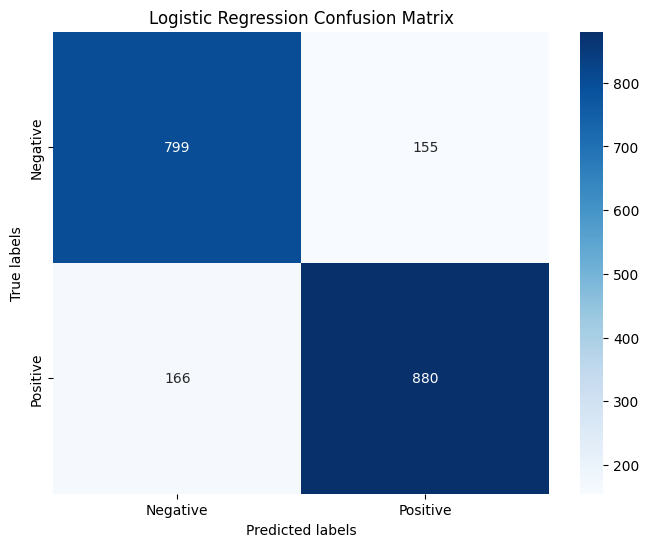

In [ ]:
#Plot Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [ ]:
# Find True Positives
tp = conf_matrix[1][1]
# Find True Negatives
tn = conf_matrix[0][0]
# Find False Positives
fp = conf_matrix[0][1]
# Find False Negatives
fn = conf_matrix[1][0]

In [ ]:
print("True Positives (TP):", tp)

True Positives (TP): 880


In [ ]:
print("True Negatives (TN):", tn)

True Negatives (TN): 799


In [ ]:
print("False Positives (FP):", fp)

False Positives (FP): 155


In [ ]:
print("False Negatives (FN):", fn)

False Negatives (FN): 166


In [ ]:
# Calculate precision, recall, F1score, FPR, FNR
precision = tp / (tp + fp)
recall = tp / (tp + fn)
FPR = fp / (fp + tn)
FNR = fn / (fn + tp)
f1 = f1_score(Y_test, X_test_prediction)

print("Precision:", np.round(precision,2))
print("Recall:", np.round(recall,2))
print("False Positive Rate (FPR):", np.round(FPR,2))
print("False Negative Rate (FNR):", np.round(FNR,2))
print("F1 Score:", np.round(f1,2))

Precision: 0.85
Recall: 0.84
False Positive Rate (FPR): 0.16
False Negative Rate (FNR): 0.16
F1 Score: 0.85


In [ ]:
#Save the trained Logistic Regression model
import pickle

In [ ]:
savedModel = 'trainedLogisticModel.sav'
pickle.dump(model, open(savedModel, 'wb'))

In [ ]:
#Using the saved model for future predictions
loadedModel = pickle.load(open('/content/trainedLogisticModel.sav', 'rb'))

In [ ]:
X_new = X_test[3]
print(Y_test[3])

prediction = loadedModel.predict(X_new)
print(prediction)

if(prediction[0] == 0):
  print('Negative tweet')

else:
  print('Positive tweet')

1
[0]
Negative tweet


In [ ]:
X_new = X_test[200]
print(Y_test[200])

prediction = loadedModel.predict(X_new)
print(prediction)

if(prediction[0] == 0):
  print('Negative tweet')

else:
  print('Positive tweet')

0
[0]
Negative tweet


**Random Forest Model**

In [ ]:
# Random Forest Model

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#Model Evaluation

#accuracy_score on the training data
X_train_prediction1 = rf_model.predict(X_train)
training_data_accuracy1 = accuracy_score(Y_train, X_train_prediction1)
print('Accuracy score on the training data:', training_data_accuracy1)

Accuracy score on the training data: 1.0


In [ ]:
#accuracy_score on the test data
X_test_prediction1 = rf_model.predict(X_test)
test_data_accuracy1 = accuracy_score(Y_test, X_test_prediction1)
print('Accuracy score on the test data:', test_data_accuracy1)

Accuracy score on the test data: 0.8295


In [ ]:
rmse1 = (np.sqrt(mean_squared_error(Y_test, X_test_prediction1)))
print('RMSE: ', np.round(rmse1,2))

RMSE:  0.41


In [ ]:
# Build confusion matrix using test data accuracy
conf_matrix1 = confusion_matrix(Y_test, X_test_prediction1)

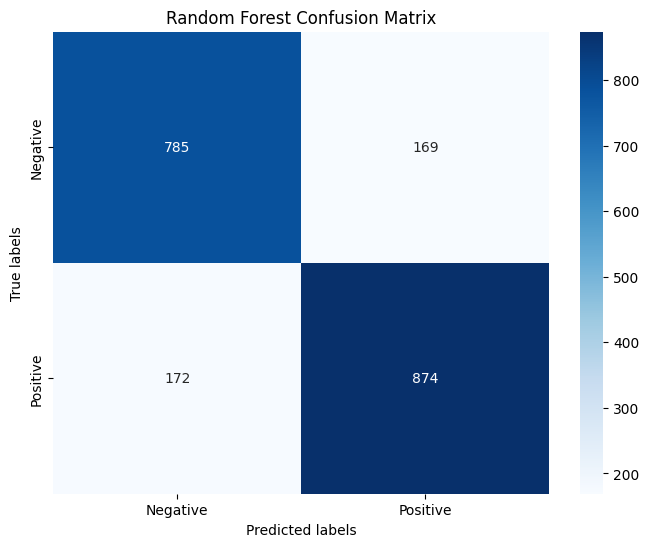

In [ ]:
#Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [ ]:
# Find True Positives
tp1 = conf_matrix1[1][1]
# Find True Negatives
tn1 = conf_matrix1[0][0]
# Find False Positives
fp1 = conf_matrix1[0][1]
# Find False Negatives
fn1 = conf_matrix1[1][0]

In [ ]:
print("True Positives (TP):", tp1)

True Positives (TP): 874


In [ ]:
print("True Negatives (TN):", tn1)

True Negatives (TN): 785


In [ ]:
print("False Positives (FP):", fp1)

False Positives (FP): 169


In [ ]:
print("False Negatives (FN):", fn1)

False Negatives (FN): 172


In [ ]:
# Calculate precision, recall, F1score, FPR, FNR
precision1 = tp1 / (tp1 + fp1)
recall1 = tp1 / (tp1 + fn1)
FPR1 = fp1 / (fp1 + tn1)
FNR1 = fn1 / (fn1 + tp1)
f1Score = f1_score(Y_test, X_test_prediction1)

print("Precision:", np.round(precision1,2))
print("Recall:", np.round(recall1,2))
print("False Positive Rate (FPR):", np.round(FPR1,2))
print("False Negative Rate (FNR):", np.round(FNR1,2))
print("F1 Score:", np.round(f1Score,2))

Precision: 0.84
Recall: 0.84
False Positive Rate (FPR): 0.18
False Negative Rate (FNR): 0.16
F1 Score: 0.84


In [ ]:
#Save Random forest for future predictions
savedModel1 = 'trainedRandomForest.sav'
pickle.dump(rf_model, open(savedModel1, 'wb'))

In [ ]:
#Using the saved model for future predictions
loadedModel1 = pickle.load(open('/content/trainedRandomForest.sav', 'rb'))

In [ ]:
X_new1 = X_test[3]
print(Y_test[3])

prediction1 = loadedModel1.predict(X_new)
print(prediction1)

if(prediction1[0] == 0):
  print('Negative tweet')

else:
  print('Positive tweet')

1
[0]
Negative tweet


In [ ]:
X_new1 = X_test[200]
print(Y_test[200])

prediction1 = loadedModel1.predict(X_new)
print(prediction1)

if(prediction1[0] == 0):
  print('Negative tweet')

else:
  print('Positive tweet')

0
[0]
Negative tweet
